In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("clinical_reports.csv")

# Drop duplicates (same image + text)
df = df.drop_duplicates(subset=["file_name", "text"])

# Shuffle and split into train (70%) and val (30%)
train_df, val_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)

# Save cleaned splits
train_df.to_csv("train_clean.csv", index=False)
val_df.to_csv("val_clean.csv", index=False)

print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")


Train size: 2009
Val size: 861


In [6]:
train_dataset = CancerDataset(
    csv_file="train_clean.csv",
    img_root="Dataset",
    tokenizer_name="emilyalsentzer/Bio_ClinicalBERT",
    feature_extractor_name="google/vit-base-patch16-224-in21k"
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

c:\Users\srava\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
val_dataset = CancerDataset(
    csv_file="val_clean.csv",
    img_root="Dataset",
    tokenizer_name="emilyalsentzer/Bio_ClinicalBERT",
    feature_extractor_name="google/vit-base-patch16-224-in21k"
)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

c:\Users\srava\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


📊 Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       1.00      1.00      1.00        33
meningioma_tumor       1.00      1.00      1.00       389
        no_tumor       1.00      1.00      1.00        93
 pituitary_tumor       1.00      1.00      1.00       346

        accuracy                           1.00       861
       macro avg       1.00      1.00      1.00       861
    weighted avg       1.00      1.00      1.00       861

✅ Accuracy Score: 100.00%


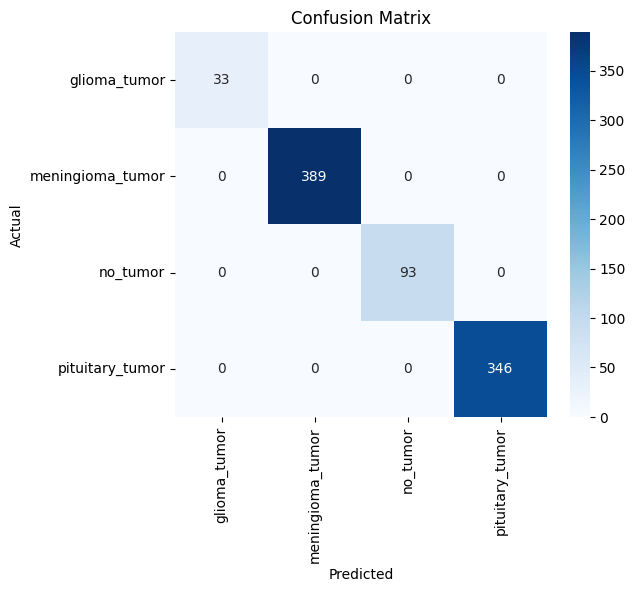

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

all_preds, all_labels = [], []

with torch.no_grad():
    for images, text_inputs, labels in val_loader:
        images = images.to(device)
        text_inputs = {k: v.to(device) for k, v in text_inputs.items()}
        labels = labels.to(device)

        outputs = model(images, text_inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

target_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
print("📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))
print(f"✅ Accuracy Score: {accuracy_score(all_labels, all_preds) * 100:.2f}%")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
